<a href="https://colab.research.google.com/github/diana-dr/Essentials-in-Text-and-Speech-Processing/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%pip install langdetect
from langdetect import detect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from statistics import mean
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

<a id="section2"></a>
# Project set-up

In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/Dataset/yelp_review.csv')
dataset.head(10)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0
5,HRPm3vEZ_F-33TYVT7Pebw,_4iMDXbXZ1p1ONG297YEAQ,8QWPlVQ6D-OExqXoaD2Z1g,5,2014-09-24,Cycle Pub Las Vegas was a blast! Got a groupon...,1,0,0
6,ymAUG8DZfQcFTBSOiaNN4w,u0LXt3Uea_GidxRW1xcsfg,9_CGhHMz8698M9-PkVf0CQ,4,2012-05-11,Who would have guess that you would be able to...,0,0,2
7,8UIishPUD92hXtScSga_gw,u0LXt3Uea_GidxRW1xcsfg,gkCorLgPyQLsptTHalL61g,4,2015-10-27,Always drove past this coffee house and wonder...,1,0,0
8,w41ZS9shepfO3uEyhXEWuQ,u0LXt3Uea_GidxRW1xcsfg,5r6-G9C4YLbC7Ziz57l3rQ,3,2013-02-09,"Not bad!! Love that there is a gluten-free, ve...",1,0,0
9,WF_QTN3p-thD74hqpp2j-Q,u0LXt3Uea_GidxRW1xcsfg,fDF_o2JPU8BR1Gya--jRIA,5,2016-04-06,Love this place!\n\nPeggy is great with dogs a...,3,0,0


In [8]:
main_dataset = dataset

In [9]:
# only keep business_id, stars, date and text columns
dataset = dataset.drop(dataset.columns[[0, 1, 6, 7, 8]], axis=1)
dataset.head(10)

,business_id,stars,date,text
0,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...
1,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...
2,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...
3,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...
4,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...
5,8QWPlVQ6D-OExqXoaD2Z1g,5,2014-09-24,Cycle Pub Las Vegas was a blast! Got a groupon...
6,9_CGhHMz8698M9-PkVf0CQ,4,2012-05-11,Who would have guess that you would be able to...
7,gkCorLgPyQLsptTHalL61g,4,2015-10-27,Always drove past this coffee house and wonder...
8,5r6-G9C4YLbC7Ziz57l3rQ,3,2013-02-09,"Not bad!! Love that there is a gluten-free, ve..."
9,fDF_o2JPU8BR1Gya--jRIA,5,2016-04-06,Love this place!\n\nPeggy is great with dogs a...


In [10]:
business = pd.read_csv('/content/drive/MyDrive/Dataset/yelp_business.csv')
business.head(10)

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...
5,o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",NaN,"""Richterstr. 11""",Stuttgart,BW,70567,48.727200,9.147950,4.0,5,1,Italian;Restaurants
6,kCoE3jvEtg6UVz5SOD3GVw,"""BDJ Realty""",Summerlin,"""2620 Regatta Dr, Ste 102""",Las Vegas,NV,89128,36.207430,-115.268460,4.0,5,1,Real Estate Services;Real Estate;Home Services...
7,OD2hnuuTJI9uotcKycxg1A,"""Soccer Zone""",NaN,"""7240 W Lake Mead Blvd, Ste 4""",Las Vegas,NV,89128,36.197484,-115.249660,1.5,9,1,Shopping;Sporting Goods
8,EsMcGiZaQuG1OOvL9iUFug,"""Any Given Sundae""",NaN,"""2612 Brandt School Rd""",Wexford,PA,15090,40.615102,-80.091349,5.0,15,1,Coffee & Tea;Ice Cream & Frozen Yogurt;Food
9,TGWhGNusxyMaA4kQVBNeew,"""Detailing Gone Mobile""",NaN,"""""",Henderson,NV,89014,36.055825,-115.046350,5.0,7,1,Automotive;Auto Detailing


In [11]:
# remove unecessary columns
business = business.drop(business.columns[[2, 3, 5, 6, 7, 8, 11]], axis=1)
business.head(10)

,business_id,name,city,stars,review_count,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,4.0,22,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",McMurray,3.0,11,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",Phoenix,1.5,18,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",Tempe,3.0,9,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",Cuyahoga Falls,3.5,116,American (New);Nightlife;Bars;Sandwiches;Ameri...
5,o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",Stuttgart,4.0,5,Italian;Restaurants
6,kCoE3jvEtg6UVz5SOD3GVw,"""BDJ Realty""",Las Vegas,4.0,5,Real Estate Services;Real Estate;Home Services...
7,OD2hnuuTJI9uotcKycxg1A,"""Soccer Zone""",Las Vegas,1.5,9,Shopping;Sporting Goods
8,EsMcGiZaQuG1OOvL9iUFug,"""Any Given Sundae""",Wexford,5.0,15,Coffee & Tea;Ice Cream & Frozen Yogurt;Food
9,TGWhGNusxyMaA4kQVBNeew,"""Detailing Gone Mobile""",Henderson,5.0,7,Automotive;Auto Detailing


In [12]:
business = business[business.categories.str.contains("Restaurant")]
business.head(10)

,business_id,name,city,stars,review_count,categories
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",Cuyahoga Falls,3.5,116,American (New);Nightlife;Bars;Sandwiches;Ameri...
5,o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",Stuttgart,4.0,5,Italian;Restaurants
10,XOSRcvtaKc_Q5H1SAzN20A,"""East Coast Coffee""",Houston,4.5,3,Breakfast & Brunch;Gluten-Free;Coffee & Tea;Fo...
14,fNMVV_ZX7CJSDWQGdOM8Nw,"""Showmars Government Center""",Charlotte,3.5,7,Restaurants;American (Traditional)
15,l09JfMeQ6ynYs5MCJtrcmQ,"""Alize Catering""",Toronto,3.0,12,Italian;French;Restaurants
19,Gu-xs3NIQTj3Mj2xYoN2aw,"""Maxim Bakery & Restaurant""",Richmond Hill,3.5,34,French;Food;Bakeries;Restaurants
25,1K4qrnfyzKzGgJPBEcJaNQ,"""Chula Taberna Mexicana""",Toronto,3.5,39,Tiki Bars;Nightlife;Mexican;Restaurants;Bars
28,Dj0S-Oe4ytRJzMGUPgYUkw,"""Panera Bread""",Elyria,2.0,4,Soup;Salad;Sandwiches;Restaurants
29,gAy4LYpsScrj8POnCW6btQ,"""Toast Cafe""",Fort Mill,3.5,6,Food;American (Traditional);Coffee & Tea;Resta...
30,nbhBRhZtdaZmMMeb2i02pg,"""Sunnyside Grill""",Toronto,5.0,3,Restaurants;Breakfast & Brunch


In [13]:
dataset = dataset[dataset.business_id.isin(business.business_id)]
dataset.head(10)

,business_id,stars,date,text
0,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...
1,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...
2,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...
3,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...
4,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...
6,9_CGhHMz8698M9-PkVf0CQ,4,2012-05-11,Who would have guess that you would be able to...
8,5r6-G9C4YLbC7Ziz57l3rQ,3,2013-02-09,"Not bad!! Love that there is a gluten-free, ve..."
10,z8oIoCT1cXz7gZP5GeU5OA,4,2013-05-01,This is currently my parents new favourite res...
11,XWTPNfskXoUL-Lf32wSk0Q,3,2011-09-28,Server was a little rude.\n\nOrdered the calam...
13,RtUvSWO_UZ8V3Wpj0n077w,3,2012-12-03,Wanted to check out this place due to all the ...


In [14]:
mean(business['review_count'])

58.96337177375069

We now want to look at is the distribution of stars.

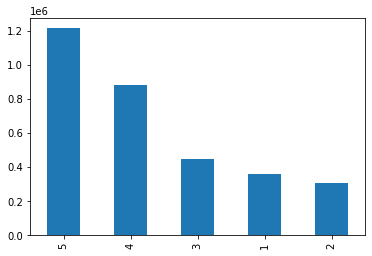

In [15]:
dataset['stars'].value_counts().plot(kind='bar')

In [16]:
dataset['business_id'].value_counts()[:1]

4JNXUYY8wbaaDmk3BPzlWw    7362
Name: business_id, dtype: int64

We notice that **5-star reviews are the most popular**, and also that **1-star reviews are more common than 2- or 3-star reviews.** We can assume that customers will go through the trouble of leaving a review only if they were highly impressed or highly disappointed.

In [17]:
dataset = dataset[dataset['business_id'] == '4JNXUYY8wbaaDmk3BPzlWw']
dataset

,business_id,stars,date,text
1720,4JNXUYY8wbaaDmk3BPzlWw,4,2017-10-25,Traditional French fare at the heart of the La...
2399,4JNXUYY8wbaaDmk3BPzlWw,5,2013-10-15,"This is my go to place for the last 12 years, ..."
3430,4JNXUYY8wbaaDmk3BPzlWw,2,2017-04-03,"Mediocre food for too much money, at least at ..."
7921,4JNXUYY8wbaaDmk3BPzlWw,4,2012-12-26,My family and I had dinner here and the wait w...
8793,4JNXUYY8wbaaDmk3BPzlWw,5,2015-10-21,Patio dining at its best. Steak au poive with ...
...,...,...,...,...
5260352,4JNXUYY8wbaaDmk3BPzlWw,5,2013-10-19,"Excellent service, excellent burger, excellent..."
5260356,4JNXUYY8wbaaDmk3BPzlWw,3,2013-12-29,Mon Ami Gabi is situated at the front of the P...
5260675,4JNXUYY8wbaaDmk3BPzlWw,3,2014-03-12,"Overpriced food, it didn't taste that good. (M..."
5260989,4JNXUYY8wbaaDmk3BPzlWw,1,2013-11-12,"Ok I will start this off by saying, the locati..."


<a id="section4"></a>
# Text Pre-processing 

<a id="section41"></a>
## Removing non-English reviews

To start, let's have a look at what language are the reviews written in.

In [18]:
dataset['detect'] = dataset['text'].apply(detect)

In [19]:
dataset = dataset[dataset['detect'] == 'en']
dataset = dataset.drop(dataset.columns[4], axis=1)
dataset

,business_id,stars,date,text
1720,4JNXUYY8wbaaDmk3BPzlWw,4,2017-10-25,Traditional French fare at the heart of the La...
2399,4JNXUYY8wbaaDmk3BPzlWw,5,2013-10-15,"This is my go to place for the last 12 years, ..."
3430,4JNXUYY8wbaaDmk3BPzlWw,2,2017-04-03,"Mediocre food for too much money, at least at ..."
7921,4JNXUYY8wbaaDmk3BPzlWw,4,2012-12-26,My family and I had dinner here and the wait w...
8793,4JNXUYY8wbaaDmk3BPzlWw,5,2015-10-21,Patio dining at its best. Steak au poive with ...
...,...,...,...,...
5260352,4JNXUYY8wbaaDmk3BPzlWw,5,2013-10-19,"Excellent service, excellent burger, excellent..."
5260356,4JNXUYY8wbaaDmk3BPzlWw,3,2013-12-29,Mon Ami Gabi is situated at the front of the P...
5260675,4JNXUYY8wbaaDmk3BPzlWw,3,2014-03-12,"Overpriced food, it didn't taste that good. (M..."
5260989,4JNXUYY8wbaaDmk3BPzlWw,1,2013-11-12,"Ok I will start this off by saying, the locati..."


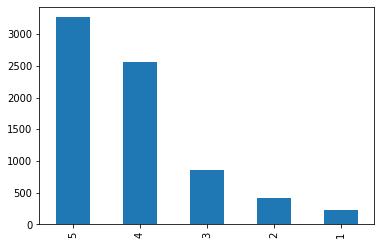

In [20]:
dataset['stars'].value_counts().plot(kind='bar')

<a id="section42"></a>
## Creating output variable (Sentiment) from Star Rating 

It would make sense to associate **4- and 5-star reviews with a positive sentiment** and **1- and 2-star reviews with a negative sentiment**.

3-star reviews would be **neutral**, but for simplicity purposes, we will only attempt to predict the positive and negative sentiment, and we will revisit neutral later. This is because our goal is to train a model to recognize positive or negative language, and 3-star reviews are likely to contain both. In normal language, neutral sentiment would mean that we are not using any words with an associated emotion, whereas this is not the case for reviews. Rather, customers assigning 3-star ratings are likely to have enjoyed some aspects and not enjoyed others. For this reason, I believe including a ''neutral' category is likely to affect our model accuracy and I would rather discard it for now. 

In [21]:
dataset = dataset[dataset['stars'] != 3]
dataset

,business_id,stars,date,text
1720,4JNXUYY8wbaaDmk3BPzlWw,4,2017-10-25,Traditional French fare at the heart of the La...
2399,4JNXUYY8wbaaDmk3BPzlWw,5,2013-10-15,"This is my go to place for the last 12 years, ..."
3430,4JNXUYY8wbaaDmk3BPzlWw,2,2017-04-03,"Mediocre food for too much money, at least at ..."
7921,4JNXUYY8wbaaDmk3BPzlWw,4,2012-12-26,My family and I had dinner here and the wait w...
8793,4JNXUYY8wbaaDmk3BPzlWw,5,2015-10-21,Patio dining at its best. Steak au poive with ...
...,...,...,...,...
5260227,4JNXUYY8wbaaDmk3BPzlWw,5,2012-08-01,A wonderful experience after last nights horre...
5260239,4JNXUYY8wbaaDmk3BPzlWw,2,2016-04-12,Did I go to the same restaurant as everyone el...
5260352,4JNXUYY8wbaaDmk3BPzlWw,5,2013-10-19,"Excellent service, excellent burger, excellent..."
5260989,4JNXUYY8wbaaDmk3BPzlWw,1,2013-11-12,"Ok I will start this off by saying, the locati..."


**Let's now create a binary variable for the sentiment:**

In [22]:
dataset['liked'] = 0
dataset.loc[dataset['stars'] > 3, 'liked'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [23]:
dataset

,business_id,stars,date,text,liked
1720,4JNXUYY8wbaaDmk3BPzlWw,4,2017-10-25,Traditional French fare at the heart of the La...,1
2399,4JNXUYY8wbaaDmk3BPzlWw,5,2013-10-15,"This is my go to place for the last 12 years, ...",1
3430,4JNXUYY8wbaaDmk3BPzlWw,2,2017-04-03,"Mediocre food for too much money, at least at ...",0
7921,4JNXUYY8wbaaDmk3BPzlWw,4,2012-12-26,My family and I had dinner here and the wait w...,1
8793,4JNXUYY8wbaaDmk3BPzlWw,5,2015-10-21,Patio dining at its best. Steak au poive with ...,1
...,...,...,...,...,...
5260227,4JNXUYY8wbaaDmk3BPzlWw,5,2012-08-01,A wonderful experience after last nights horre...,1
5260239,4JNXUYY8wbaaDmk3BPzlWw,2,2016-04-12,Did I go to the same restaurant as everyone el...,0
5260352,4JNXUYY8wbaaDmk3BPzlWw,5,2013-10-19,"Excellent service, excellent burger, excellent...",1
5260989,4JNXUYY8wbaaDmk3BPzlWw,1,2013-11-12,"Ok I will start this off by saying, the locati...",0


<a id="section43"></a>
## Creating input variables - *Bag of Words* approach

The following block of code processes the text by transforming it into lowercase, removing the puntuation and the common English words ( such as "this", "and" and so on).

In [72]:
corpus = []
nltk.download('stopwords')
for row in dataset.itertuples():
    review = re.sub('[^a-zA-Z]', ' ', row.text)
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's see how one of our reviews looks now.

In [73]:
corpus[1]

'go place last year consist dish amaz wine select larg group famili dinner consist ppl food tast exactli great price strip restaur must appit liver mouss pate steak bordelais favorit diet free day ask roquefort sauc pomm fritt best dish plat du jour beef wellington thursday sunday tip tri shrimp gabi appit still order even though menu year'

In [74]:
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(corpus).toarray()
y = dataset.iloc[:, 4].values

In [75]:
y

array([1, 1, 0, ..., 1, 0, 0])

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [77]:
X_train[0, 0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [78]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [79]:
y_pred_NB = classifier.predict(X_test)

In [80]:
cm_NB = confusion_matrix(y_test, y_pred_NB) 
cm_NB

array([[122,  20],
       [675, 479]])

In [81]:
TP_NB = 680 #True Positives (Naive Bayes)
TN_NB = 108 #True Negatives (Naive Bayes)
FP_NB = 476 #False Positives (Naive Bayes)
FN_NB = 31 #False Negatives (Naive Bayes)

In [82]:
Accuracy_NB = (TP_NB + TN_NB) / (TP_NB + TN_NB + FP_NB + FN_NB) 
Accuracy_NB  

0.6084942084942085

In [83]:
Precision_NB = TP_NB / (TP_NB + FP_NB)
Precision_NB

0.5882352941176471

In [84]:
Recall_NB = TP_NB / (TP_NB + FN_NB)
Recall_NB

0.9563994374120957

In [85]:
F1_Score_NB = 2 * Precision_NB * Recall_NB / (Precision_NB + Recall_NB) 
F1_Score_NB

0.7284413497589715

In [86]:
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [87]:
y_pred_DT = classifier.predict(X_test)
y_pred_DT

array([1, 0, 0, ..., 1, 1, 1])

In [88]:
cm_DT = confusion_matrix(y_test, y_pred_DT) 
cm_DT

array([[  62,   80],
       [  65, 1089]])

In [89]:
TP_DT = 1091 #True Positives (Decision Tree)
TN_DT = 70 #True Negatives (Decision Tree)
FP_DT = 65 #False Positives (Decision Tree)
FN_DT = 69 #False Negatives (Decision Tree)

In [90]:
Accuracy_DT = (TP_DT + TN_DT) / (TP_DT + TN_DT + FP_DT + FN_DT)
Accuracy_DT

0.8965250965250965

In [91]:
Precision_DT = TP_DT / (TP_DT + FP_DT)
Precision_DT

0.9437716262975778

In [92]:
Recall_DT = TP_DT / (TP_DT + FN_DT)
Recall_DT

0.9405172413793104

In [93]:
F1_Score_DT = 2 * Precision_DT * Recall_DT / (Precision_DT + Recall_DT)
F1_Score_DT

0.9421416234887737

In [94]:
classifier = RandomForestClassifier(n_estimators = 300, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=300, random_state=0)

In [95]:
y_pred_RF = classifier.predict(X_test)
y_pred_RF

array([1, 1, 1, ..., 1, 1, 1])

In [96]:
cm_RF = confusion_matrix(y_test, y_pred_RF) 
cm_RF

array([[  30,  112],
       [   2, 1152]])

In [97]:
TP_RF = 1156 #True Positives (Random Forest)
TN_RF = 12 #True Negatives (Random Forest)
FP_RF = 0 #False Positives (Random Forest)
FN_RF = 127 #False Negatives (Random Forest)

In [98]:
Accuracy_RF = (TP_RF + TN_RF) / (TP_RF + TN_RF + FP_RF + FN_RF)
Accuracy_RF

0.901930501930502

In [99]:
Precision_RF = TP_RF / (TP_RF + FP_RF)
Precision_RF

1.0

In [100]:
Recall_RF = TP_RF / (TP_RF + FN_RF)
Recall_RF

0.9010132501948558

In [101]:
F1_Score_RF = 2 * Precision_RF * Recall_RF / (Precision_RF + Recall_RF)
F1_Score_RF

0.947929479294793

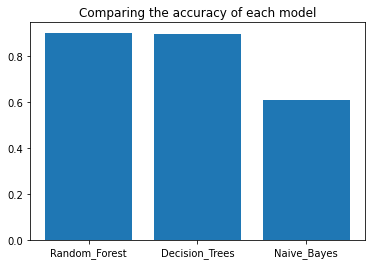

In [102]:
Accuracy = [Accuracy_RF, Accuracy_DT, Accuracy_NB]
Methods = ['Random_Forest', 'Decision_Trees', 'Naive_Bayes']
Accuracy_pos = np.arange(len(Methods))
plt.bar(Accuracy_pos, Accuracy)
plt.xticks(Accuracy_pos, Methods)
plt.title('Comparing the accuracy of each model')
plt.show()

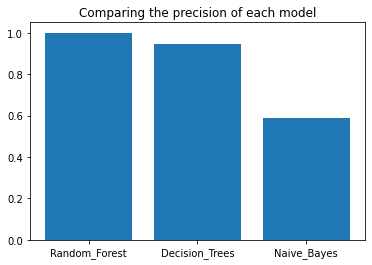

In [103]:
Precision = [Precision_RF, Precision_DT, Precision_NB]
Precision_pos = np.arange(len(Methods))
plt.bar(Precision_pos, Precision)
plt.xticks(Precision_pos, Methods)
plt.title('Comparing the precision of each model')
plt.show()

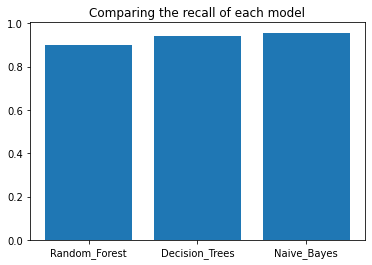

In [104]:
Recall = [Recall_RF, Recall_DT, Recall_NB]
Recall_pos = np.arange(len(Methods))
plt.bar(Recall_pos, Recall)
plt.xticks(Recall_pos, Methods)
plt.title('Comparing the recall of each model')
plt.show()

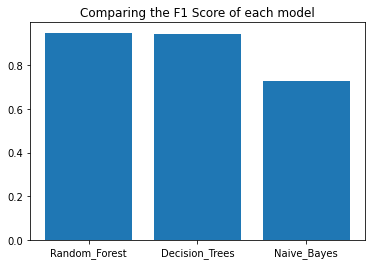

In [105]:
F1_Score = [F1_Score_RF, F1_Score_DT, F1_Score_NB]
F1_Score_pos = np.arange(len(Methods))
plt.bar(F1_Score_pos, F1_Score)
plt.xticks(F1_Score_pos, Methods)
plt.title('Comparing the F1 Score of each model')
plt.show()